# Calculating the Big Mac index

This R script shows how _The Economist_ calculates its Big Mac index.

We use the `tidyverse` and `data.table` packages for working with data generally.

In [1]:
library('tidyverse')
library('data.table')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




We only calculate the Big Mac index for certain countries, specifically these ones:

In [2]:
big_mac_countries = c('ARG', 'AUS', 'BRA', 'GBR', 'CAN', 'CHL', 'CHN', 'CZE', 'DNK',
                      'EGY', 'HKG', 'HUN', 'IDN', 'ISR', 'JPN', 'MYS', 'MEX', 'NZL',
                      'NOR', 'PER', 'PHL', 'POL', 'RUS', 'SAU', 'SGP', 'ZAF', 'KOR',
                      'SWE', 'CHE', 'TWN', 'THA', 'TUR', 'ARE', 'USA', 'COL', 'CRI',
                      'PAK', 'LKA', 'UKR', 'URY', 'IND', 'VNM', 'GTM', 'HND', 'VEN',
                      'NIC', 'AZE', 'BHR', 'HRV', 'JOR', 'KWT', 'LBN', 'MDA', 'OMN',
                      'QAT', 'ROU', 'EUZ')

Our raw data sheet, compiled every six months, contains three sets of data: the local price of a Big Mac, the exchange rate of the local currency to the US dollar, and the GDP per person of the country (in US dollars). We have these data compiled into a single file already, so we can just load it. But we also have a handful of specific manual price corrections (usually countries to be omitted for specific reasons; see the CSV itself for more details).

In [3]:
big_mac_data = fread('./source-data/big-mac-source-data-v2.csv', na.strings = '#N/A') %>%
    .[,GDP_local := as.numeric(GDP_local)] %>%    # convert GDP to a number
    # account for manual corrections--we get these occasionally
    merge(
        fread('./source-data/price-corrections.csv')[,.(date, iso_a3, local_price)], 
        by=c('date', 'iso_a3'),
        all.x=T
    ) %>%
    .[,`:=`(
        local_price=ifelse(is.na(local_price.y), local_price.x, local_price.y),
        local_price.x=NULL,
        local_price.y=NULL
    )] %>%
    .[, local_price := ifelse(local_price == '-', NA, local_price) %>% as.numeric] %>%
    .[!is.na(local_price)] %>%                    # remove lines where the local price is missing
    .[order(date, name)]                         # sort by date and then by country name, for easy reading

tail(big_mac_data)

date,iso_a3,name,currency_code,dollar_ex,GDP_dollar,GDP_local,local_price
<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
2023-01-01,UKR,Ukraine,UAH,36.9170,NA,NA,92.00
2023-01-01,ARE,United Arab Emirates,AED,3.6730,47792.94,175519.57,18.00
2023-01-01,USA,United States,USD,1.0000,75179.59,75179.59,5.36
2023-01-01,URY,Uruguay,UYU,39.1250,20017.56,839339.49,268.00
2023-01-01,VEN,Venezuela,VES,20.7081,3051.74,25029.66,56.30
2023-01-01,VNM,Vietnam,VND,23450.0000,4162.94,93807820.60,72000.00


In [4]:
latest_date = big_mac_data$date %>% max
latest_date

[1] "2023-01-01"

### Converting to a uniform currency

Our first step to calculate the index is to convert all of the prices to a uniform currency (we use the US dollar).

In [5]:
big_mac_data[, dollar_price := local_price / dollar_ex]
tail(big_mac_data)

date,iso_a3,name,currency_code,dollar_ex,GDP_dollar,GDP_local,local_price,dollar_price
<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2023-01-01,UKR,Ukraine,UAH,36.9170,NA,NA,92.00,2.492077
2023-01-01,ARE,United Arab Emirates,AED,3.6730,47792.94,175519.57,18.00,4.900626
2023-01-01,USA,United States,USD,1.0000,75179.59,75179.59,5.36,5.360000
2023-01-01,URY,Uruguay,UYU,39.1250,20017.56,839339.49,268.00,6.849840
2023-01-01,VEN,Venezuela,VES,20.7081,3051.74,25029.66,56.30,2.718743
2023-01-01,VNM,Vietnam,VND,23450.0000,4162.94,93807820.60,72000.00,3.070362


### Calculating the raw index

Now that we've done this, we can pick out our five 'base' currencies: the US dollar (USD), Euro (EUR), British pound (GBP), Japanese yen (JPY), and Chinese yuan (CNY).

In [6]:
base_currencies = c('USD', 'EUR', 'GBP', 'JPY', 'CNY')

Calculating the index is as simple as dividing the local price by the price in the base currency. We're using `data.table`'s grouping abilities to do this neatly.

In [7]:
big_mac_index = big_mac_data[
    !is.na(dollar_price) & iso_a3 %in% big_mac_countries
    ,.(date, iso_a3, currency_code, name, local_price, dollar_ex, dollar_price)]

for(currency in base_currencies) {
    big_mac_index[
        ,                           # we don't want a subset, so our first argument is blank
        (currency) :=               # we'll add a new column named for the base set
            dollar_price /          # we divide the dollar price in each row by
                                    # the dollar price on the *base currency*'s row (.SD is a data.table
            .SD[currency_code == currency]$dollar_price -        # that contains only the current group)
            1,                      # one means parity (neither over- nor under-valued), so we subtract one
                                    # to get an over/under-valuation value
        by=date                     # and of course, we'll group these rows by date
    ]
}
big_mac_index[, (base_currencies) := round(.SD, 5L), .SDcols=base_currencies]
tail(big_mac_index)

date,iso_a3,currency_code,name,local_price,dollar_ex,dollar_price,USD,EUR,GBP,JPY,CNY
<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2023-01-01,UKR,UAH,Ukraine,92.00,36.9170,2.492077,-0.53506,-0.52851,-0.46604,-0.20922,-0.29557
2023-01-01,ARE,AED,United Arab Emirates,18.00,3.6730,4.900626,-0.08570,-0.07281,0.05001,0.55505,0.38525
2023-01-01,USA,USD,United States,5.36,1.0000,5.360000,0.00000,0.01410,0.14844,0.70082,0.51510
2023-01-01,URY,UYU,Uruguay,268.00,39.1250,6.849840,0.27796,0.29597,0.46766,1.17357,0.93624
2023-01-01,VEN,VES,Venezuela,56.30,20.7081,2.718743,-0.49277,-0.48562,-0.41748,-0.13730,-0.23150
2023-01-01,VNM,VND,Vietnam,72000.00,23450.0000,3.070362,-0.42717,-0.41910,-0.34214,-0.02572,-0.13210


We can also see a basic plot, like so:

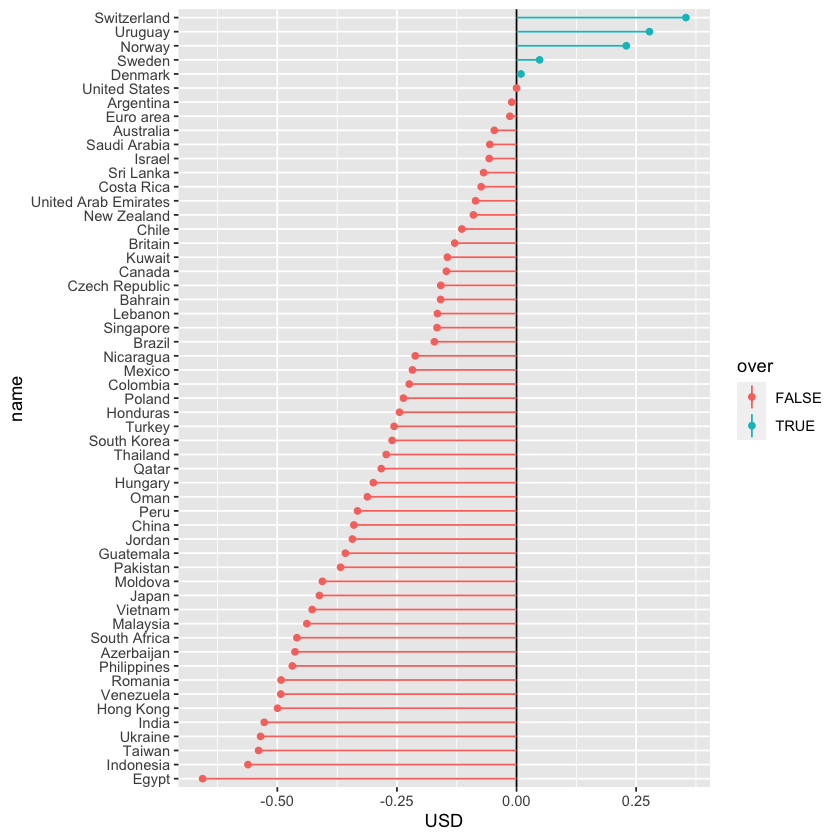

In [8]:
to_plot = big_mac_index[date == latest_date]
to_plot$name = factor(to_plot$name, levels=to_plot$name[order(to_plot$USD)])
ggplot(to_plot[, over := USD > 0], aes(x=name, y=USD, color=over)) +
    geom_hline(yintercept = 0) +
    geom_linerange(aes(ymin=0, ymax=USD)) +
    geom_point() +
    coord_flip()

We've now calculated the index. We'll save it to a file.

In [9]:
fwrite(big_mac_index, './output-data/big-mac-raw-index.csv')

Lovely! We've got it. So what about that adjusted index?

## Calculating the adjusted index

While the Big Mac index is a refreshingly simple way of thinking about relative currency values, a common (and fair) objection to it is that burgers cannot be easily traded across borders. Given non-traded local inputs (rent and worker’s wages) one would expect Big Macs to be cheaper in poorer countries and dearer in wealthier ones.

We'll start out by only picking the countries where we have GDP data.

In [10]:
big_mac_gdp_data = big_mac_data[GDP_local > 0]
head(big_mac_gdp_data)

date,iso_a3,name,currency_code,dollar_ex,GDP_dollar,GDP_local,local_price,dollar_price
<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2000-04-01,ARG,Argentina,ARS,1.0000000,8709.07,8709.07,2.50,2.500000
2000-04-01,AUS,Australia,AUD,1.6800000,21748.00,33700.61,2.59,1.541667
2000-04-01,BRA,Brazil,BRL,1.7900000,3501.44,6351.38,2.95,1.648045
2000-04-01,GBR,Britain,GBP,0.6329114,28733.21,17755.61,1.90,3.002000
2000-04-01,CAN,Canada,CAD,1.4700000,22340.55,33191.47,2.85,1.938776
2000-04-01,CHL,Chile,CLP,514.0000000,4980.14,2533797.20,1260.00,2.451362


In order to correct for the problem, we'll use a linear regression of GDP vs Big Mac Price.

We sometimes add or remove countries from the Big Mac index, but we want the list of countries on which we base the adjusted index to remain consistent. We use this list of countries to calculate the relationship between GDP and Big Mac price.

In [11]:
regression_countries = c('ARG', 'AUS', 'BRA', 'GBR', 'CAN', 'CHL', 'CHN', 'CZE', 'DNK',
                         'EGY', 'EUZ', 'HKG', 'HUN', 'IDN', 'ISR', 'JPN', 'MYS', 'MEX',
                         'NZL', 'NOR', 'PER', 'PHL', 'POL', 'RUS', 'SAU', 'SGP', 'ZAF',
                         'KOR', 'SWE', 'CHE', 'TWN', 'THA', 'TUR', 'USA', 'COL', 'PAK',
                         'IND', 'AUT', 'BEL', 'NLD', 'FIN', 'FRA', 'DEU', 'IRL', 'ITA',
                         'PRT', 'ESP', 'GRC', 'EST')
# in 2021, we added a number of additional countries to the adjusted index
regression_addons_2021 = c('ARE', 'CRI', 'LKA', 'UKR', 'URY', 'VNM', 'GTM', 'HND', 'NIC',
                           'AZE', 'BHR', 'HRV', 'JOR', 'KWT', 'MDA', 'OMN', 'QAT', 'ROU',
                           'SVK', 'SVN', 'LVA', 'LTU')
big_mac_gdp_data = big_mac_gdp_data[iso_a3 %in% regression_countries |
  (iso_a3 %in% regression_addons_2021 & date >= as.Date('2021-01-01'))
]

tail(big_mac_gdp_data)

date,iso_a3,name,currency_code,dollar_ex,GDP_dollar,GDP_local,local_price,dollar_price
<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2023-01-01,THA,Thailand,THB,32.8225,7630.87,247238.01,128.00,3.899764
2023-01-01,TUR,Turkey,TRY,18.8055,9961.07,166790.98,75.00,3.988195
2023-01-01,ARE,United Arab Emirates,AED,3.6730,47792.94,175519.57,18.00,4.900626
2023-01-01,USA,United States,USD,1.0000,75179.59,75179.59,5.36,5.360000
2023-01-01,URY,Uruguay,UYU,39.1250,20017.56,839339.49,268.00,6.849840
2023-01-01,VNM,Vietnam,VND,23450.0000,4162.94,93807820.60,72000.00,3.070362


We create a new "Big-Mac-adjusted per-capita GDP", which is the GDP in local currency, divided by the exchange rate as determined by Big Macs (that is, the price in local currency divided by the price in the United States). This performs a similar function to "purchasing-power parity" adjustments, but using only the price of a Big Mac to make the adjustment.

In [12]:
big_mac_gdp_data %>%
    .[,GDP_bigmac := GDP_local / (local_price / .SD[iso_a3=='USA']$local_price), by=date]
tail(big_mac_gdp_data)

date,iso_a3,name,currency_code,dollar_ex,GDP_dollar,GDP_local,local_price,dollar_price,GDP_bigmac
<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2023-01-01,THA,Thailand,THB,32.8225,7630.87,247238.01,128.00,3.899764,10353.092
2023-01-01,TUR,Turkey,TRY,18.8055,9961.07,166790.98,75.00,3.988195,11919.995
2023-01-01,ARE,United Arab Emirates,AED,3.6730,47792.94,175519.57,18.00,4.900626,52265.828
2023-01-01,USA,United States,USD,1.0000,75179.59,75179.59,5.36,5.360000,75179.590
2023-01-01,URY,Uruguay,UYU,39.1250,20017.56,839339.49,268.00,6.849840,16786.790
2023-01-01,VNM,Vietnam,VND,23450.0000,4162.94,93807820.60,72000.00,3.070362,6983.471


Now that we have our consistent basket of "regression countries", we can run our regressions. We can see what that looks like:

`geom_smooth()` using formula 'y ~ x'



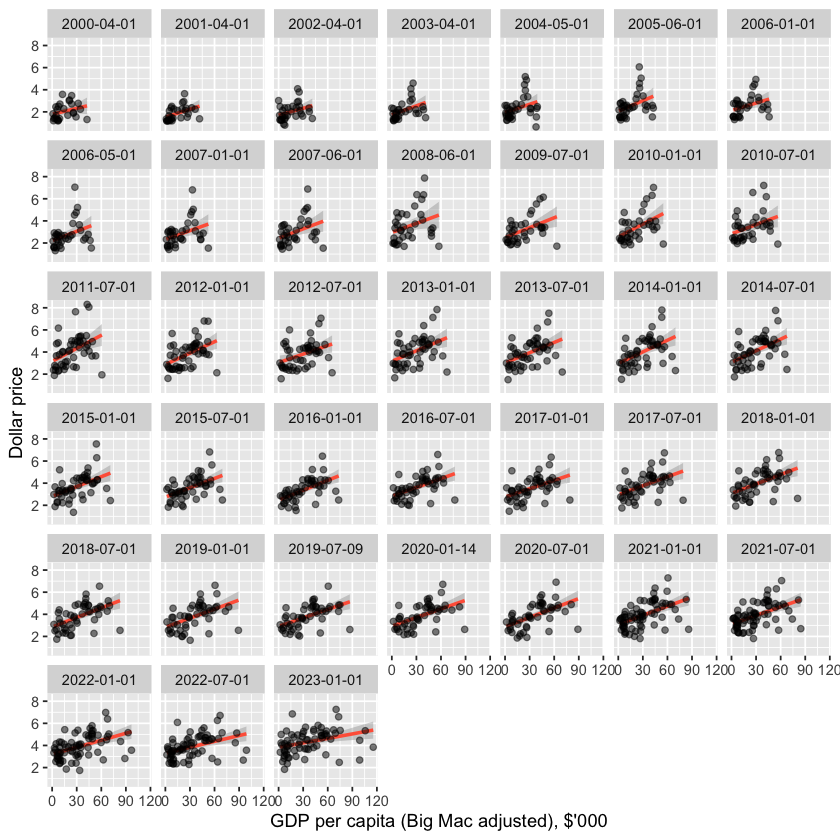

In [13]:
ggplot(big_mac_gdp_data, aes(x=GDP_bigmac, y=dollar_price)) +
    facet_wrap(~date)+
    geom_smooth(method = lm, color='tomato') +
    geom_point(alpha=0.5) +
    scale_x_continuous(labels=function(x) {round(x / 1000)}) +
    labs(y="Dollar price", x="GDP per capita (Big Mac adjusted), $'000")

We have to calculate the regressions separately for each date (ggplot did this for us above).

In [14]:
big_mac_gdp_data[date=='2022-07-01']

date,iso_a3,name,currency_code,dollar_ex,GDP_dollar,GDP_local,local_price,dollar_price,GDP_bigmac
<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2022-07-01,ARG,Argentina,ARS,129.115000,10616.95,1009600.06,590.00,4.569570,8812.611
2022-07-01,AUS,Australia,AUD,1.448436,63464.11,84418.53,6.70,4.625680,64888.870
2022-07-01,AUT,Austria,EUR,0.975850,53332.27,45062.16,4.35,4.457652,53349.454
2022-07-01,AZE,Azerbaijan,AZN,1.698250,5397.93,9176.48,4.70,2.767555,10055.079
2022-07-01,BHR,Bahrain,BHD,0.377000,26135.78,9827.05,1.60,4.244032,31630.817
2022-07-01,BEL,Belgium,EUR,0.975850,51849.34,43809.19,4.60,4.713839,49047.245
2022-07-01,BRA,Brazil,BRL,5.391750,7563.56,40823.76,22.90,4.247230,9180.889
2022-07-01,GBR,Britain,GBP,0.831080,47328.78,34402.82,3.69,4.440006,48014.776
2022-07-01,CAN,Canada,CAD,1.289150,52015.07,65220.49,5.88,4.561145,57123.388


In [15]:
big_mac_gdp_data[
    ,
    `:=`(
        adj_price=lm(dollar_price ~ GDP_bigmac) %>% predict
#         adj_price_USD=lm(dollar_price ~ GDP_dollar) %>% predict
    ),
    by = date]
tail(big_mac_gdp_data)

date,iso_a3,name,currency_code,dollar_ex,GDP_dollar,GDP_local,local_price,dollar_price,GDP_bigmac,adj_price
<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2023-01-01,THA,Thailand,THB,32.8225,7630.87,247238.01,128.00,3.899764,10353.092,3.964421
2023-01-01,TUR,Turkey,TRY,18.8055,9961.07,166790.98,75.00,3.988195,11919.995,3.985625
2023-01-01,ARE,United Arab Emirates,AED,3.6730,47792.94,175519.57,18.00,4.900626,52265.828,4.531599
2023-01-01,USA,United States,USD,1.0000,75179.59,75179.59,5.36,5.360000,75179.590,4.841677
2023-01-01,URY,Uruguay,UYU,39.1250,20017.56,839339.49,268.00,6.849840,16786.790,4.051484
2023-01-01,VNM,Vietnam,VND,23450.0000,4162.94,93807820.60,72000.00,3.070362,6983.471,3.918822


If we've done everything right, all the points we just generated should be on those lines from above...

`geom_smooth()` using formula 'y ~ x'



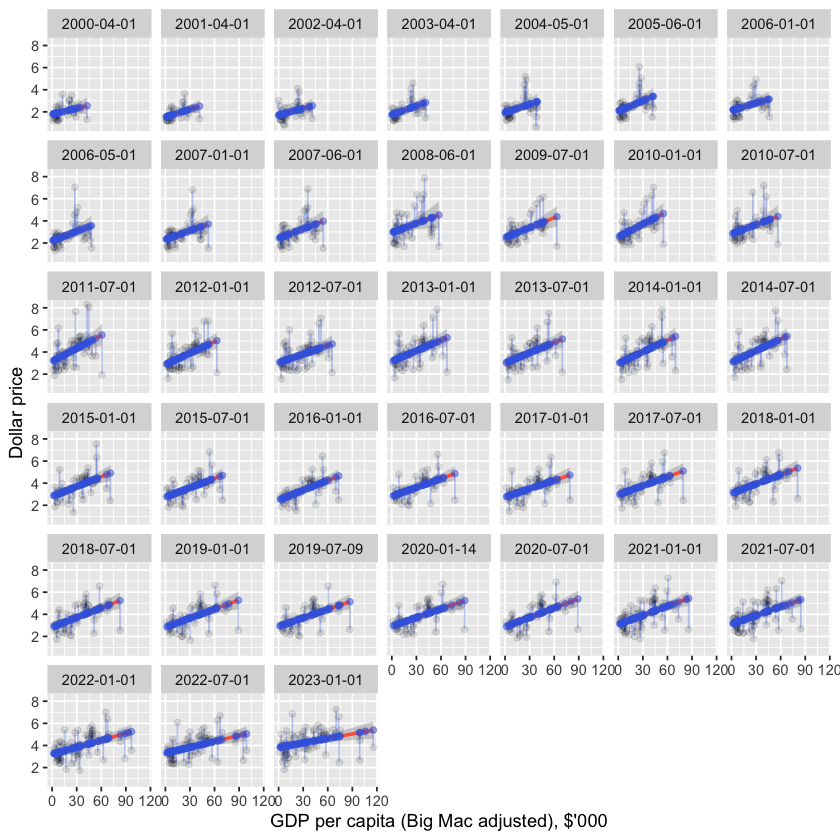

In [16]:
ggplot(big_mac_gdp_data, aes(x=GDP_bigmac, y=dollar_price)) +
    facet_wrap(~date) +
    geom_smooth(method = lm, color='tomato') +
    geom_linerange(aes(ymin=dollar_price, ymax=adj_price), color='royalblue', alpha=0.3) +
    geom_point(alpha=0.1) +
    geom_point(aes(y=adj_price), color='royalblue', alpha=0.5) +
    scale_x_continuous(labels=function(x) {round(x / 1000)}) +
    labs(y="Dollar price", x="GDP per capita (Big Mac adjusted), $'000")

Yep, that's exactly what we wanted. So now that we've got these data, we can do almost the same thing as before.

In [17]:
big_mac_adj_index = big_mac_gdp_data[
    !is.na(dollar_price) &
    (
        iso_a3 %in% regression_countries |
        iso_a3 %in% regression_addons_2021 & date >= '2021-01-01'
    ) &
    iso_a3 %in% big_mac_countries
    ,.(date, iso_a3, currency_code, name, local_price, dollar_ex, dollar_price, GDP_bigmac, adj_price)]

for(currency in base_currencies) {
    big_mac_adj_index[
        ,                           # we don't want a subset, so our first argument is blank
        (currency) :=               # we'll add a new column named for the base set
            (                       # we divide the dollar price by the adjusted price to get
                dollar_price / adj_price  # the deviation from our expectation by
            ) /
                                    # the same figure from the *base currency*'s rowa\
            (
                .SD[currency_code == currency]$dollar_price /
                .SD[currency_code == currency]$adj_price
            ) -
            1,                      # one means parity (neither over- nor under-valued), so we subtract one
                                    # to get an over/under-valuation value
        by=date                     # and of course, we'll group these rows by date
    ]
}
big_mac_adj_index[, (base_currencies) := round(.SD, 5L), .SDcols=base_currencies]

tail(big_mac_adj_index)

date,iso_a3,currency_code,name,local_price,dollar_ex,dollar_price,GDP_bigmac,adj_price,USD,EUR,GBP,JPY,CNY
<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2023-01-01,THA,THB,Thailand,128.00,32.8225,3.899764,10353.092,3.964421,-0.11143,-0.18035,-0.04211,0.43738,0.13668
2023-01-01,TUR,TRY,Turkey,75.00,18.8055,3.988195,11919.995,3.985625,-0.09612,-0.16622,-0.02560,0.46216,0.15627
2023-01-01,ARE,AED,United Arab Emirates,18.00,3.6730,4.900626,52265.828,4.531599,-0.02314,-0.09890,0.05307,0.58021,0.24962
2023-01-01,USA,USD,United States,5.36,1.0000,5.360000,75179.590,4.841677,0.00000,-0.07755,0.07802,0.61764,0.27923
2023-01-01,URY,UYU,Uruguay,268.00,39.1250,6.849840,16786.790,4.051484,0.52720,0.40877,0.64635,1.47047,0.95364
2023-01-01,VNM,VND,Vietnam,72000.00,23450.0000,3.070362,6983.471,3.918822,-0.29227,-0.34716,-0.23706,0.14485,-0.09466


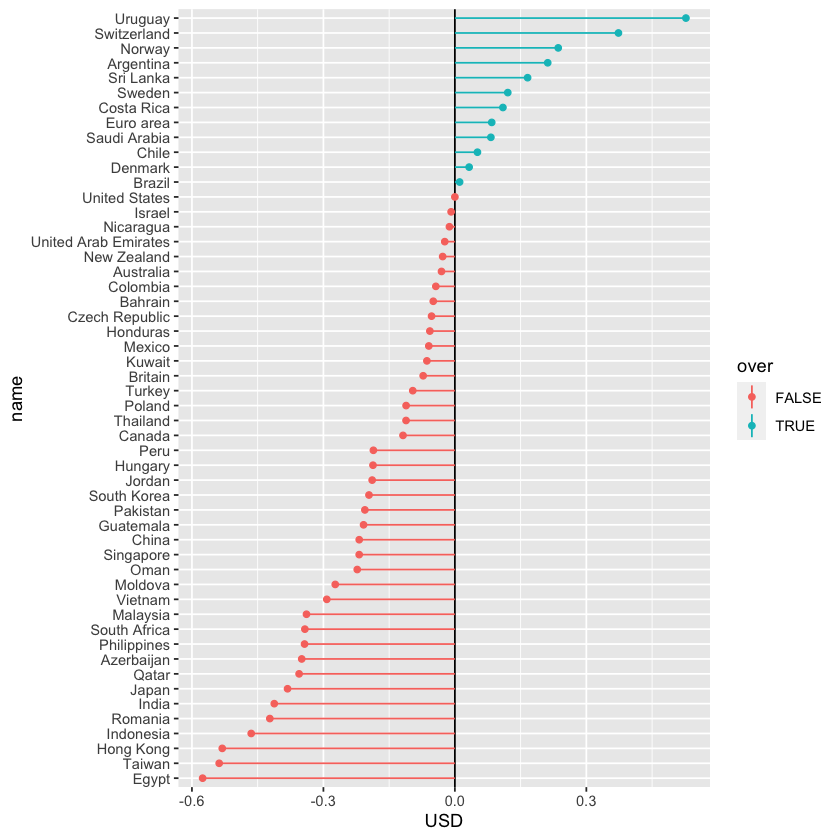

In [18]:
to_plot = big_mac_adj_index[date == latest_date]
to_plot$name = factor(to_plot$name, levels=to_plot$name[order(to_plot$USD)])
ggplot(to_plot[, over := USD > 0], aes(x=name, y=USD, color=over)) +
    geom_hline(yintercept = 0) +
    geom_linerange(aes(ymin=0, ymax=USD)) +
    geom_point() +
    coord_flip()

In [19]:
fwrite(big_mac_adj_index, './output-data/big-mac-adjusted-index.csv')

Also, for tidiness, we'll generate a consolidated file with both indices in one table.

In [20]:
big_mac_full_index = merge(big_mac_index, big_mac_adj_index,
      by=c('date', 'iso_a3', 'currency_code', 'name', 'local_price', 'dollar_ex', 'dollar_price'),
      suffixes=c('_raw', '_adjusted'),
      all.x=TRUE
     )
tail(big_mac_full_index)

date,iso_a3,currency_code,name,local_price,dollar_ex,dollar_price,USD_raw,EUR_raw,GBP_raw,JPY_raw,CNY_raw,GDP_bigmac,adj_price,USD_adjusted,EUR_adjusted,GBP_adjusted,JPY_adjusted,CNY_adjusted
<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2023-01-01,UKR,UAH,Ukraine,92.00,36.9170,2.492077,-0.53506,-0.52851,-0.46604,-0.20922,-0.29557,NA,NA,NA,NA,NA,NA,NA
2023-01-01,URY,UYU,Uruguay,268.00,39.1250,6.849840,0.27796,0.29597,0.46766,1.17357,0.93624,16786.790,4.051484,0.52720,0.40877,0.64635,1.47047,0.95364
2023-01-01,USA,USD,United States,5.36,1.0000,5.360000,0.00000,0.01410,0.14844,0.70082,0.51510,75179.590,4.841677,0.00000,-0.07755,0.07802,0.61764,0.27923
2023-01-01,VEN,VES,Venezuela,56.30,20.7081,2.718743,-0.49277,-0.48562,-0.41748,-0.13730,-0.23150,NA,NA,NA,NA,NA,NA,NA
2023-01-01,VNM,VND,Vietnam,72000.00,23450.0000,3.070362,-0.42717,-0.41910,-0.34214,-0.02572,-0.13210,6983.471,3.918822,-0.29227,-0.34716,-0.23706,0.14485,-0.09466
2023-01-01,ZAF,ZAR,South Africa,49.90,17.2100,2.899477,-0.45905,-0.45143,-0.37875,-0.07995,-0.18041,11654.156,3.982027,-0.34227,-0.39328,-0.29096,0.06397,-0.15862


In [21]:
fwrite(big_mac_full_index, './output-data/big-mac-full-index.csv')